# Machine Learning Engineer Nanodegree
## Capstone Project : DeepTesla
Guangwei Wang  
March 20st, 2017

## Definition
### Project Overview

This project is based on Course [MIT 6.S094: Deep Learning for Self-Driving Cars](http://selfdrivingcars.mit.edu/deeptesl/)


### Problem Statement

This project is an end-to-end learning problem. The goal is to predict the steering wheel angel from Tesla dataset based on the video of the forward roadway.

### Datasets and Inputs

Databases with real-traffic video data captured and extracted 10 video clips of highway driving from Tesla:

- The wheel value was extracted from the in-vehicle CAN

- A window from each video frame is cropped/extracted and provide a CSV linking the window to a wheel value.

A snapshot of video frame:
<img src="./images/img/frame_1173.jpg" width = "320" height = "180" align=center />
    
The CSV data format:


|  ts_micro         | frame_index | wheel |
|:-----------------:|:-----------:|:-----:|
|  1464305394391807 | 0           | -0.5  |
| 1464305394425141  | 1           | -0.5  | 
| 1464305394458474  | 2           | -0.5  |


### Evaluation Metrics

This is a regression problem, MSE metrics is adopted here.

$$MSE = \frac{1}{N} \sum_{N}^{i=1}\sqrt{y_{p} - y}$$
where, $y_p$ is the predicted steering wheel angle, $y$ denotes the reference steering wheel angle, and the sample number is `N`. The lower MSE is preferred.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Import local env
import params
import helper
import preprocess

data_dir = params.data_dir
out_dir = params.out_dir
model_dir = params.model_dir

img_height = params.img_height
img_width = params.img_width
img_channels = params.img_channels
batch_size = params.batch_size

### Steering angle info

In [ ]:
import glob
csv_files = glob.glob(os.path.join(data_dir, "*steering.csv"))
steering_csv = pd.concat((pd.read_csv(f) for f in csv_files))

In [ ]:
steering_csv[-3:]

In [ ]:
steering_csv.describe()

In [ ]:
steering_csv.wheel.describe()

In [ ]:
wheel = steering_csv['wheel']
plt.figure
plt.hist(wheel,50);

In [ ]:
import cv2
import matplotlib.image as mpimg
img=mpimg.imread("images/img/frame_1173.jpg")
imgplot = plt.imshow(img)

In [ ]:
img = preprocess.preprocess(img)
imgplot = plt.imshow(img)

In [ ]:
cap = cv2.VideoCapture("epochs/epoch03_front.mkv")
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = int(cap.get(cv2.CAP_PROP_FPS))

print (length,width,height,fps)

The frame count of video is large than csv 2 frame counts

- Merge all frames together with corresponding steering wheel angle.
- Show one frame of the preprocessed data.

In [ ]:
imgs_wheels_train = preprocess.load_data('train')
helper.display_states(imgs_wheels_train,100)

# shuffle dataframe rows
imgs_wheels_train = imgs_wheels_train.sample(frac=1).reset_index(drop=True)
# Normalize
imgs_wheels_train.imgs = imgs_wheels_train.imgs / 255.

In [ ]:
imgs_wheels_val = preprocess.load_data('valid')
helper.display_states(imgs_wheels_val,100)

# shuffle dataframe rows
imgs_wheels_val = imgs_wheels_val.sample(frac=1).reset_index(drop=True)
# Normalize
imgs_wheels_val.imgs = imgs_wheels_val.imgs / 255.

In [ ]:
imgs_wheels_train.imgs[1].shape

In [ ]:
import preprocess

## Data Processing V2

In [4]:
np.array(imgs_train).shape

(24300, 66, 200, 3)

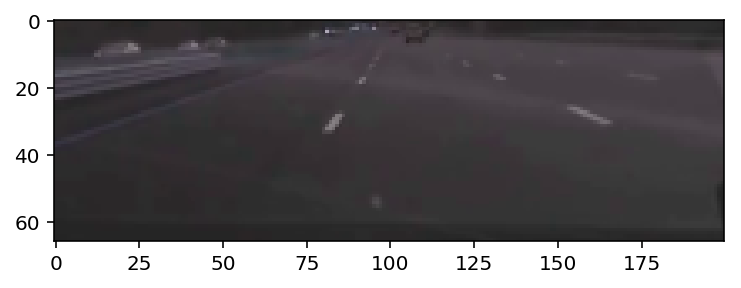

In [3]:
imgs_train, wheels_train = preprocess.load_data_v2('train')
plt.imshow(imgs_train[1])

In [ ]:
imgs_val, wheels_val = preprocess.load_data_v2 ('valid')
plt.imshow(imgs_val[1])

In [ ]:
# To do. Save the check point data
# pikle has memory error, hasn't solved

## Check point

The data has been processed by
- Merge data together
- Shuffle
- Normalize

In [ ]:
import helper

### Convolution and Max Pooling Layer

In [5]:
import tensorflow as tf

def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides):
    """
    Apply convolution to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :return: A tensor that represents convolution of x_tensor
    """
    _,_,_,input_depth = x_tensor.get_shape()
    weight = tf.Variable(tf.truncated_normal((*conv_ksize,int(input_depth),conv_num_outputs),
                                             mean=0.0, stddev=0.1), name='weight')
    bias = tf.Variable(tf.truncated_normal([conv_num_outputs]), name='bias')
    
    # Apply a convolution, add bias, and add nonlinear activation
    x_tensor = tf.nn.conv2d(x_tensor, 
                            weight, 
                            strides = [1,*conv_strides,1], 
                            padding = 'SAME')
    x_tensor = tf.nn.bias_add(x_tensor, bias)
    return tf.nn.relu(x_tensor)

def max_pool(x_tensor, pool_ksize, pool_strides):
    """
    Apply max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    :return: A tensor that represents max pooling of x_tensor
    """
    return tf.nn.max_pool(x_tensor, 
                          ksize = [1,*pool_ksize,1], 
                          strides = [1,*pool_strides,1], 
                          padding = 'SAME')

### Flatten Layer

In [6]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    # If one component of shape is the special value -1, 
    # the size of that dimension is computed so that the total size remains constant.
    _, size_x, size_y, depth = x_tensor.get_shape()
    return tf.reshape(x_tensor, [-1, int(size_x)*int(size_y)*int(depth)])

### Fully-Connected Layer

In [7]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    weight = tf.Variable(tf.truncated_normal((int(x_tensor.get_shape()[1]),num_outputs),
                                             mean=0.0, stddev=0.05))
    bias = tf.Variable(tf.truncated_normal([num_outputs]))
    y = tf.nn.bias_add(tf.matmul(x_tensor, weight), bias)
    return tf.nn.relu(y)

### Output Layer

In [8]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    weight = tf.Variable(tf.truncated_normal((int(x_tensor.get_shape()[1]),num_outputs),
                                             mean=0.0, stddev=0.05))
    bias = tf.Variable(tf.truncated_normal([num_outputs]))
    return tf.nn.bias_add(tf.matmul(x_tensor, weight), bias)

### Convolutional Model

In [9]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    conv_1 = conv2d(x_tensor=x,
                           conv_num_outputs=24,
                           conv_ksize=[3,3],
                           conv_strides=[1,1])
    conv_1 = max_pool(x_tensor = conv_1,
                      pool_ksize=[3,3],
                      pool_strides=[2,2])
    
    conv_2 = conv2d(x_tensor=conv_1,
                    conv_num_outputs=36,
                    conv_ksize=[3,3],
                    conv_strides=[1,1])
    conv_2 = max_pool(x_tensor = conv_2,
                     pool_ksize=[3,3],
                     pool_strides=[2,2])
    
    conv_3 = conv2d(x_tensor=conv_2,
                    conv_num_outputs=48,
                    conv_ksize=[3,3],
                    conv_strides=[1,1])
    conv_3 = max_pool(x_tensor = conv_3,
                     pool_ksize=[3,3],
                     pool_strides=[2,2])
    
    conv_4 = conv2d(x_tensor=conv_3,
                    conv_num_outputs=64,
                    conv_ksize=[3,3],
                    conv_strides=[1,1])
    conv_4 = max_pool(x_tensor = conv_4,
                     pool_ksize=[3,3],
                     pool_strides=[2,2])
    
    
    fc0 = flatten(conv_4)
    
    fc1 = fully_conn(fc0, 256)     
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    fc2 = fully_conn(fc1, 256)     
    fc2 = tf.nn.dropout(fc2, keep_prob)
    
    out = output(fc2, 1)
    return out

In [10]:
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32,
                   [None, params.img_height, params.img_width, params.img_channels], 
                   name='x')
y_ = tf.placeholder(tf.float32, [None, 1], name='y_')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')


# Model
y = conv_net(x, keep_prob)
y = tf.identity(y, name='y')

# Lost and Optimizer
loss = tf.reduce_mean(tf.square(tf.sub(y_, y)))
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

# Accuracy


In [13]:
epochs = 1000
batch_size = 128
keep_probability = 0.5

In [ ]:
np.array(imgs_train).shape

In [ ]:
txx, tyy = helper.load_batch_v2(imgs_train, wheels_train)

In [ ]:
np.array(txx).shape

In [ ]:
this_x = np.reshape(tyy,(batch_size,1))

In [ ]:
this_x.shape

In [ ]:
len(imgs_train)

In [ ]:
import helper

In [18]:
import time
saver = tf.train.Saver()
time_start = time.time()




print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        txx, tyy = helper.load_batch_v2(imgs_train[:-2000], wheels_train[:-2000])
        tyy = np.reshape(tyy,(batch_size,1))
        train_step.run(feed_dict={x: txx, y_: tyy, keep_prob: keep_probability})
        
        
        #for batch_features, batch_targetss in txx, tyy:
        #    train_neural_network(sess, optimizer, keep_probability, batch_features, batch_targets)
        #if (i+1) % 10 == 0:
        #vxx, vyy = imgs_val, wheels_val
        if (epoch+1) % 10 == 0:
            vxx, vyy = imgs_train[-2000:], wheels_train[-2000:]
            vyy = np.reshape(vyy,(len(vyy),1))
            t_loss = loss.eval(feed_dict={x: txx, y_: tyy, keep_prob: 1.0})
            v_loss = loss.eval(feed_dict={x: vxx, y_: vyy, keep_prob: 1.0})
            print ("step {} of {}, train loss {}, val loss {}".format(epoch+1, epochs, t_loss, v_loss))
            
        if (epoch+1) % 100 == 0:
            if not os.path.exists(params.model_dir):
                os.makedirs(params.save_dir)
            checkpoint_path = os.path.join(params.model_dir, "model.ckpt")
            filename = saver.save(sess, checkpoint_path)
            time_end = time.time()
            time_passed = int(round(time_end - time_start))
            print ('Model saved. Time passed: {}s. '.format(time_passed))

Checking the Training on a Single Batch...
step 10 of 1000, train loss 29.355796813964844, val loss 5.637911796569824
step 20 of 1000, train loss 35.885528564453125, val loss 24.41329002380371
step 30 of 1000, train loss 24.78249740600586, val loss 3.9814462661743164
step 40 of 1000, train loss 20.724552154541016, val loss 4.219688415527344
step 50 of 1000, train loss 16.765239715576172, val loss 5.494463920593262
step 60 of 1000, train loss 19.15953254699707, val loss 8.186609268188477
step 70 of 1000, train loss 20.43023109436035, val loss 6.391333103179932
step 80 of 1000, train loss 26.663049697875977, val loss 5.14324951171875
step 90 of 1000, train loss 21.25088119506836, val loss 4.7052998542785645
step 100 of 1000, train loss 17.65384292602539, val loss 5.324472904205322
Model saved. Time passed: 26. 
step 110 of 1000, train loss 18.033891677856445, val loss 3.8881983757019043
step 120 of 1000, train loss 22.150775909423828, val loss 3.4446511268615723
step 130 of 1000, train l

## Checkpoint
The model has been saved.

## Test Model

Test the trained model on epoch 10 video.

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper, params
import random

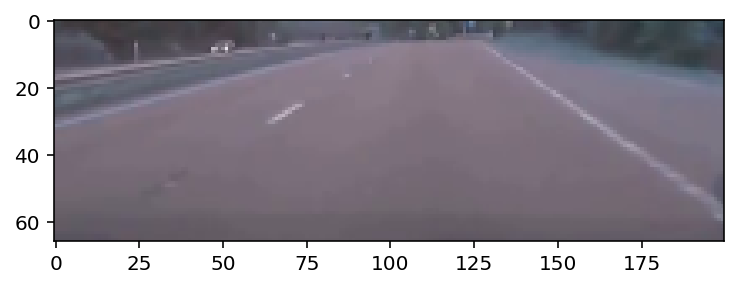

In [21]:
imgs_test, wheels_test = preprocess.load_data_v2('test')
plt.imshow(imgs_test[1])

In [34]:
def test_model():
    '''Test the saved model against the epoch 10 video'''
    with tf.Session() as sess:
    # Initializing the variables
        sess.run(tf.global_variables_initializer())
        checkpoint_path = os.path.join(params.model_dir, "model.ckpt")
        loader = tf.train.import_meta_graph(checkpoint_path + '.meta')
        loader.restore(sess, checkpoint_path)
        
        test_xx, test_yy = helper.load_batch_v2(imgs_test, wheels_test)
        test_yy = np.reshape(test_yy,(batch_size,1))
        test_loss = loss.eval(feed_dict={x: test_xx, y_: test_yy, keep_prob: 1.0})
        print('Testing Loss: {}\n'.format(test_loss))

In [35]:
test_model()

Testing Loss: 6.477058410644531

